# Gain modulation in the balanced state

The definition of __[balanced state](https://doi.org/10.1007/978-1-4614-6675-8_573)__ (or __high-conductance state__) in the [Encyclopedia of Computational Neuroscience](https://doi.org/10.1007/978-1-4614-6675-8) is the following:

_The balanced state of neurons is characterized by a high value of the total membrane conductance caused by synaptic inputs. It is the state of cortical neurons in vivo in awake animals, and it is due to massive excitatory and inhibitory inputs that almost cancel out. In this state, the responses are driven by fluctuations (possible also due to coincident events) in the input, and due to a greatly reduced effective membrane time constant, the neuron responds rapidly_.

Here, we simulate the balanced state using the [Brian simulator](https://brian2.readthedocs.io/en/stable/), which allows us to easily define the equations that describe the neuron and synaptic dynamics. On top of the reconstructed background synaptic activity, we will inject constant steps of currents to compute an f-I curve and investigate the effects of gain modulation, as exemplified in the figure below (taken from [1]):

<img src="gain_modulation.png" width=500px/>

#### References
[1] Chance, F.S., Abbott, L.F. and Reyes, A.D., 2002. _Gain modulation from background synaptic input_. Neuron, 35(4), pp.773-782, doi:[10.1016/s0896-6273(02)00820-6](https://doi.org/10.1016/s0896-6273(02)00820-6)

In [1]:
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
import seaborn as sns
integration_method = 'exponential_euler'

#### Definition of the neuron
Let's start with the parameters of a simple LIF neuron:

In [2]:
C      =  400*pF
tau    =   20*ms
EL     = - 70*mV
Vth    = - 54*mV
Vreset = - 65*mV
# refractory period
tarp   =    5*ms
# derived values
Rm     = tau/C
gL     =   1/Rm

... then its equations, which also include the vector field of the synaptic conductances and corresponding current:

In [3]:
neuron_eqs = Equations("""
dV/dt = (gL*(EL-V) + I_syn + I_ext) / C : volt (unless refractory)
I_syn = g_AMPA * (E_exc-V) + g_GABA * (E_inh-V) : amp
dg_AMPA/dt = -g_AMPA / tau_AMPA : siemens
dg_GABA/dt = -g_GABA / tau_GABA : siemens
""")
thresh_cond = 'V>Vth'
reset_action= 'V=Vreset'

... and finally we instantiate a `NeuronGroup` containing only 1 cell:

In [4]:
cell = NeuronGroup(1, model=neuron_eqs, threshold=thresh_cond, reset=reset_action,
                   refractory=tarp, method=integration_method, name='neuron')
# initialize the Vm of the cell
cell.V = EL

#### Synapse parameters
Let's define the parameters of single-exponential conductance-based synapses:

In [5]:
E_exc    =   0*mV
E_inh    = -80*mV
tau_AMPA =   5*ms
tau_GABA =  10*ms
# reasonable values for unitary conductances
g0_AMPA = 0.05*nS
g0_GABA = 0.20*nS

Here we instantiate two objects that will generate presynaptic spike trains whose inter-spike intervals are exponentially distributed (i.e., if we compute the CV of the ISIs, we should get a value close to 1):

In [6]:
# let's keep a 5:1 ratio between excitatory and inhibitory presynaptic cells
N_exc = 1000
N_inh =  200
cond = '1x'
if cond == '0x':
    nu_exc = 0*1*Hz
    nu_inh = 0*4*Hz
elif cond == '1x':
    nu_exc = 5*Hz
    nu_inh = 20*Hz
else:
    nu_exc = 2*5*Hz
    nu_inh = 2*20*Hz
poisson_pre_exc = PoissonGroup(N_exc, rates=nu_exc, name='poisson_pre_exc')
poisson_pre_inh = PoissonGroup(N_inh, rates=nu_inh, name='poisson_pre_inh')

Here we instantiate the synapse objects:

In [7]:
syn_exc = Synapses(poisson_pre_exc, cell, model='w_AMPA: siemens', on_pre='g_AMPA += w_AMPA',
                   method=integration_method, name='syn_exc')
syn_inh = Synapses(poisson_pre_inh, cell, model='w_GABA: siemens', on_pre='g_GABA += w_GABA',
                   method=integration_method, name='syn_inh')

...and connect them to the post-synaptic neuron (`p=1` means that the probability of connections is 1, i.e., all presynaptic sources will be connected to the postsynaptic target):

In [8]:
syn_exc.connect(p=1)
syn_inh.connect(p=1)
syn_exc.w_AMPA = g0_AMPA
syn_inh.w_GABA = g0_GABA

#### State and spike monitors
These are used to record continuous variables (e.g., voltage and conductances) and discrete events such as spikes.

In [9]:
post_spike_mon    = SpikeMonitor(cell)
pre_exc_spike_mon = SpikeMonitor(poisson_pre_exc)
pre_inh_spike_mon = SpikeMonitor(poisson_pre_inh)
state_mon = StateMonitor(cell, ['V','g_AMPA','g_GABA'], record=True)

### Computation of the f-I curve of the model with background synaptic input

Here we inject steps of DC current on top of the background synaptic input: each value of current is injected for `stim_dur` ms.

In [10]:
I = np.r_[300 : 1050 : 50] * pA
interval = 20*tau
t_before = 10*interval
stim_dur = 1000*ms
I_ext = 0*pA
run(t_before)
for i in I:
    I_ext = i
    run(stim_dur)
    I_ext = 0*pA
    run(interval)

Read the continuous variables from the state monitors:

In [11]:
t = state_mon.t / ms
V = state_mon.V[0] / mV
g_AMPA = state_mon.g_AMPA[0] / nS
g_GABA = state_mon.g_GABA[0] / nS
I_AMPA = g_AMPA * (E_exc/mV - V) # (pA)
I_GABA = g_GABA * (E_inh/mV - V) # (pA)
I_syn = I_AMPA + I_GABA

Here we plot the membrane voltage, the excitatory and inhibitory conductances and associated currents, plus the net synaptic current, as "seen" from the soma, for the condition in which there is no additional DC current, i.e., for the first `t_before` ms.

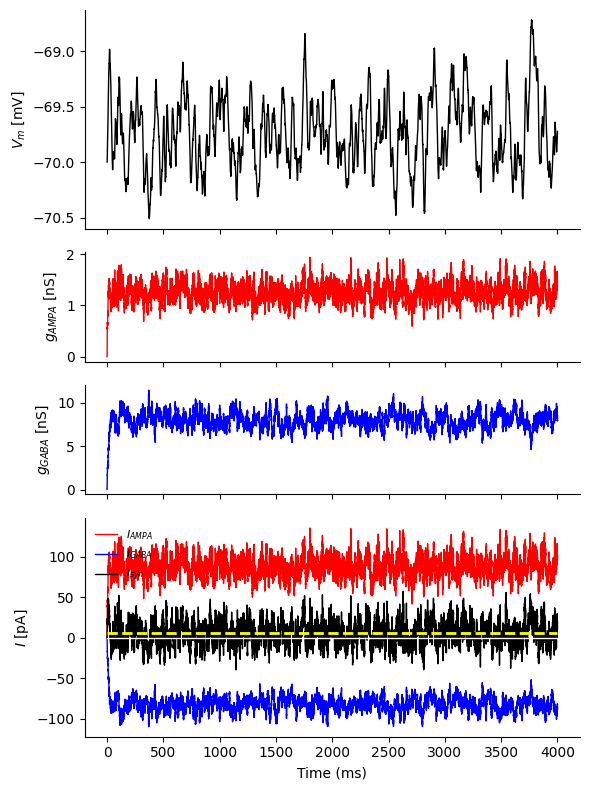

In [12]:
idx, = np.where(t < t_before/ms)
fig,ax = plt.subplots(4, 1, figsize=(6,8), height_ratios=(2,1,1,2), sharex=True)
ax[0].plot(t[idx], V[idx], 'k', lw=1)
ax[1].plot(t[idx], g_AMPA[idx], 'r', lw=1)
ax[2].plot(t[idx], g_GABA[idx], 'b', lw=1)
ax[3].plot(t[idx], I_AMPA[idx], 'r', lw=1, label=r'$I_{AMPA}$')
ax[3].plot(t[idx], I_GABA[idx], 'b', lw=1, label=r'$I_{GABA}$')
ax[3].plot(t[idx], I_syn[idx], 'k', lw=1, label=r'$I_{syn}$')
ax[3].plot(t[idx[[0,-1]]], I_syn[idx].mean()+np.zeros(2), '--', color=[1,1,0], lw=2)
ax[3].plot(t[idx[[0,-1]]], np.zeros(2), color=[1,1,1], lw=1)
ax[-1].set_xlabel('Time (ms)')
ax[0].set_ylabel(r'$V_m$ [mV]')
ax[1].set_ylabel(r'$g_{AMPA}$ [nS]')
ax[2].set_ylabel(r'$g_{GABA}$ [nS]')
ax[3].set_ylabel(r'$I$ [pA]')
ax[3].legend(loc='best', frameon=False, fontsize=8)
sns.despine()
fig.tight_layout()
plt.savefig(f'V_G_I_{cond}.pdf')

Here we collect the post-synaptic spike times from the `SpikeMonitor` object and compute the corresponding f-I curve:

In [13]:
spike_times = post_spike_mon.t/ms
firing_rate = np.zeros_like(I)
for i in range(I.size):
    tstart = (t_before + i*(stim_dur+interval))/ms
    tstop = tstart + stim_dur/ms
    idx = (spike_times > tstart) & (spike_times <= tstop)
    firing_rate[i] = np.sum(idx)

This is the theoretical f-I curve of a LIF neuron, for the case where no background synaptic input is present:

In [14]:
II = np.linspace(I[0], I[-1], 100)
idx = (EL + II/gL ) >= Vth
firing_rate_theory = np.zeros_like(II)
firing_rate_theory[idx] = 1 / (tarp-C/gL*np.log((gL*(Vth-EL)-II[idx])/(gL*(Vreset-EL)-II[idx])))

Plot both f-I curves:

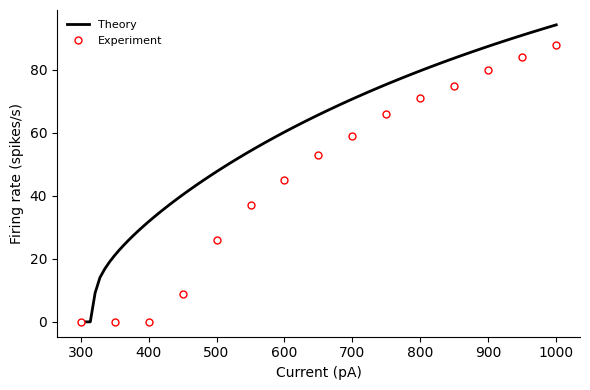

In [15]:
fig,ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(II/pA, firing_rate_theory, 'k', lw=2, label='Theory')
ax.plot(I/pA, firing_rate, 'ro', markerfacecolor='w', markersize=5, markeredgewidth=1, label='Experiment')
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (spikes/s)')
ax.legend(loc='upper left', frameon=False, fontsize=8)
sns.despine()
fig.tight_layout()
plt.savefig(f'fI_curve_{cond}.pdf')